In [1]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from src.model_specpred import SpectrumPredictor
from src.utils_model import lorentzian, spec_to_Sqt, batch_spec_to_Sqt

from matplotlib.colors import to_rgb, to_rgba

from matplotlib.colors import Normalize
from scipy.interpolate import interp1d
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

torch.set_default_dtype(torch.float64)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

c:\Users\zhant\.conda\envs\sqt\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import seaborn
palette_crest = seaborn.color_palette(palette='crest')
palette_flare = seaborn.color_palette(palette='flare')

In [3]:
model_spec = SpectrumPredictor.load_from_checkpoint("production_models/version_large_training_set/checkpoints/epoch=8456-step=422850.ckpt")

In [4]:
data = torch.load("data/CrI3/20221110.pt")
X = data['param'][:,:2]
Y = torch.cat((data['omega'], data['inten']), dim=1)

indices_dict = torch.load("data_splitting/indices_42_800-100-100.pt")
train_indices = indices_dict['train']
val_indices = indices_dict['val']
test_indices = indices_dict['test']

X_train = X[train_indices]
Y_train = Y[train_indices]
train_dataset = TensorDataset(X_train, Y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X_test = X[test_indices]
Y_test = Y[test_indices]

print("print some values for further reference:")
# print("training:\n", X_train[:5])
# print("validation:\n", X_val[:5])
print("testing:\n", X_test[:5])

print some values for further reference:
testing:
 tensor([[-1.5924e+00, -2.1911e-01],
        [-2.9503e+00, -8.5994e-04],
        [-1.6105e+00, -2.4190e-01],
        [-2.3308e+00, -4.2538e-01],
        [-1.8445e+00, -5.6670e-01]])


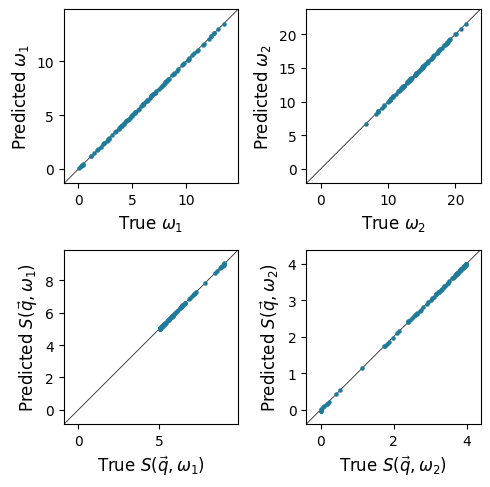

In [5]:
model_spec.to(device)

loss_test = []
Y_test_pred = []
with torch.no_grad():
    for x_test, y_test in zip(X_test, Y_test):
        y_test_pred = model_spec(x_test.to(device)).detach().cpu()
        loss_test.append((y_test_pred - y_test).abs().mean().item())
        Y_test_pred.append(y_test_pred)
Y_test_pred = torch.vstack(Y_test_pred)

labels = [r'$\omega_1$', r'$\omega_2$', r'$S(\vec{q},\omega_{1})$', r'$S(\vec{q},\omega_{2})$']

fig = plt.figure(figsize=(5,5))
gs = plt.GridSpec(2,2)
for i in range(4):
    ax = fig.add_subplot(gs[i])
    ax.plot([-100,100], [-100,100], 'k', linewidth=0.5, zorder=0)
    ax.scatter(Y_test[:,i], Y_test_pred[:,i], s=5, color="#207A9A", zorder=10)
    ax.set_aspect('equal')
    ax.set_xlim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_ylim([-0.1*Y_test[:,i].max(), 1.1*Y_test[:,i].max()])
    ax.set_xlabel(f"True {labels[i]}", fontsize=12)
    ax.set_ylabel(f"Predicted {labels[i]}", fontsize=12)

fig.tight_layout()
# fig.savefig("figs/paper/network_hist2d.pdf", bbox_inches='tight')

In [6]:
# from laplace.baselaplace import FullLaplace, DiagLaplace
# from laplace.curvature.backpack import BackPackGGN

# from laplace import Laplace, marglik_training

In [7]:
print(model_spec)

SpectrumPredictor(
  (fc_net): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=4, bias=False)
  )
)


In [8]:
# la = Laplace(model_spec.fc_net.to(device), 
#              'regression', 
#              subset_of_weights='all', 
#              hessian_structure='kron',)
# la.fit(train_dataloader)

In [9]:
# log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
# hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)
# for i in tqdm(range(10)):
#     hyper_optimizer.zero_grad()
#     neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
#     neg_marglik.backward()
#     hyper_optimizer.step()

In [10]:
gamma = 0.1
# times = np.arange(0,3,0.01)
times = np.linspace(0, 3, 121)
settings = (times, )
n_particles = 501
parameters = (
    np.random.uniform(-3.0, -2.0, n_particles),
    np.random.uniform(-1.0,-0.0, n_particles),
    np.random.uniform( 0.0, 1.0, n_particles),
    np.random.uniform( 0.0, 0.0, n_particles),
    np.random.uniform( 0.1, 2.0, n_particles)
    )

In [11]:
%load_ext autoreload
%autoreload 2
from src.bayes import BayesianInference, jit_batch_spec_to_Sqt
from src.utils_model import tensor2array, array2tensor
import optbayesexpt as obe
from src.utils_convolution import get_I_conv, interp_nb

In [12]:
from src.utils_general import prepare_sample

def measure_function(sets, pars, cons, func):
    """ Evaluates a trusted model of the experiment's output
    The equivalent of a fit function. The argument structure is
    required by OptBayesExpt.
    Args:
        sets: A tuple of setting values, or a tuple of settings arrays
        pars: A tuple of parameter arrays or a tuple of parameter values
        cons: A tuple of floats
    Returns:  the evaluated function
    """
    # unpack the settings
    # t, = sets
    # unpack model parameters
    t, = sets
    if isinstance(t, (int, float)):
        t = np.array([t,])
    else:
        t = np.atleast_1d(tensor2array(t))
    I_pred = func(t)
    return I_pred

In [13]:
target_idx = 40

pulse_width = 0.1
noise_level = 0.5
N_steps_bayes = 40
normalize_to_value = 100

mean gamma is:  tensor([[1.0218],
        [1.0218]])


c:\Users\zhant\Dropbox\SLAC\research\TopologicalSpinML\topo-spin-Sqt-ML-main\src\utils_convolution.py:19: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if isinstance(t, (int, float)):
c:\Users\zhant\Dropbox\SLAC\research\TopologicalSpinML\topo-spin-Sqt-ML-main\src\CrI3\prepare.py:155: RuntimeWarning: divide by zero encountered in log10
  ax.imshow(np.log10(Z_raw), extent=[HH0_raw.min(), HH0_raw.max(), E_raw.min(), E_raw.max()], origin='lower')


(None, None, 0.07184370194751377, 0.0, 0.5)


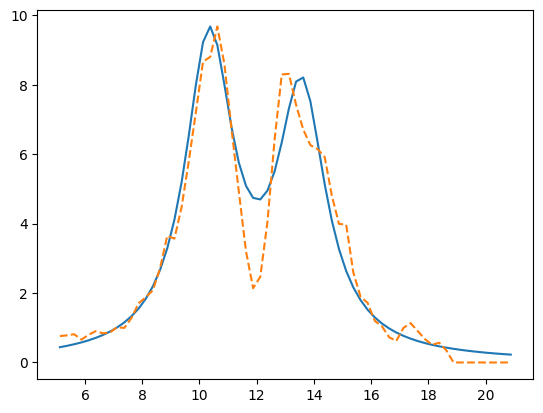

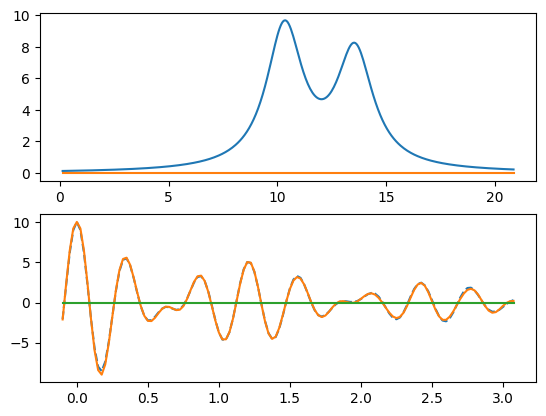

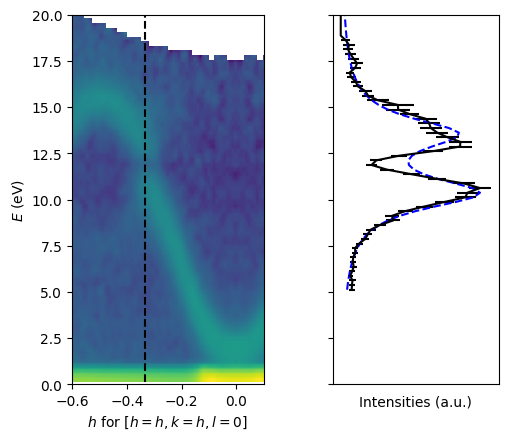

In [14]:
from src.CrI3.prepare import prepare_CrI3_sample

param_true, func_I_conv, func_I_noconv = prepare_CrI3_sample(times, pulse_width=0.1, mode='lorentzian', E_cutoff=5.0,
                    amp_increase_factor=0.95, elas_bkg_amp_factor=0., elas_bkg_wid=0.5)
print(param_true)

(None, None, 0.07184370194751377, 0.0, 0.5)


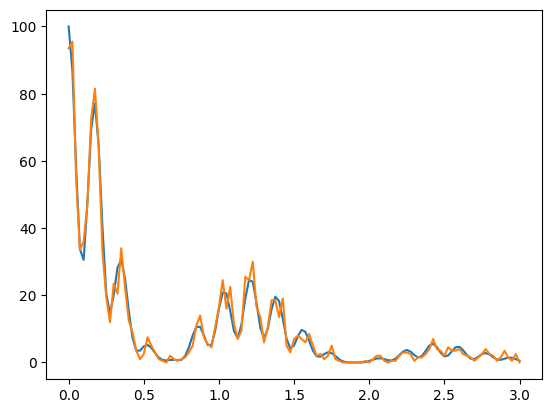

In [15]:
# param_true, func_I_conv, func_I_noconv = \
#     prepare_sample(X_test[target_idx], Y_test[target_idx], gamma, times, 
#                    pulse_width=pulse_width, visualize=True, normalize_to_value=normalize_to_value,
#                    elas_amp_factor=0.5850576985324748, elas_wid=0.5, elas_amp_abs_max=1000.)

# param_true, func_I_conv, func_I_noconv = \
#     prepare_CrI3_sample(times, amp_increase_factor=1.05, pulse_width=pulse_width)
print(param_true)
obe_sim = obe.MeasurementSimulator(
    lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=noise_level, noise_mode='poisson')
obe_sim_noisefree = obe.MeasurementSimulator(
    lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=0)

plt.figure()
plt.plot(times, obe_sim_noisefree.simdata((times,)))
plt.plot(times, obe_sim.simdata((times,)))
# plt.figure()
# plt.plot(times, np.log(obe_sim.simdata((times,))))
# plt.plot(times, np.log(obe_sim_noisefree.simdata((times,))))

In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
from src.bayes import BayesianInference
bayes = BayesianInference(
    model_spec, settings, parameters, noise_level=noise_level,
    pulse_width=pulse_width, reference_setting_value=((0,), normalize_to_value),
    cost_repulse_height=10.0, cost_repulse_width=0.25,
    parameter_mins=(-3,-1,0,0,0.1), parameter_maxs=(-2,0,1,10,2), 
    selection_method='unique_optimal', utility_method='variance_full',
    model_uncertainty=False, device=device)
# bayes.obe_model.set_selection_method('unique_optimal')
# bayes.obe_model.set_selection_method('sequential')

c:\Users\zhant\Dropbox\SLAC\research\TopologicalSpinML\topo-spin-Sqt-ML-main\src\bayes.py:225: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.meV_to_2piTHz).to(y).clone().detach(),
c:\Users\zhant\Dropbox\SLAC\research\TopologicalSpinML\topo-spin-Sqt-ML-main\src\bayes.py:229: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(self.meV_to_2piTHz).to(y).clone().detach(),


In [18]:
# bayes.obe_model.set_selection_method('sequential')
particles_hist, p_weights_hist, errors, likyhd_hist = bayes.run_N_steps_OptBayesExpt_w_GD(
    40, obe_sim, N_GD=100, lr=0.01, ret_particles=True, verbose=True,
    gd_seperation=14, error_criterion=10)
# particles_hist, p_weights_hist = bayes.run_N_steps_OptBayesExpt(
#     100, obe_sim, ret_particles=True, verbose=True)
print(bayes.obe_model.mean(), bayes.obe_model.std())

using the unique_optimal setting


Running OptBayesExpt:  35%|███▌      | 14/40 [00:08<00:04,  6.31it/s]

running GD at step 14, current error 695.0611834166696


c:\Users\zhant\Dropbox\SLAC\research\TopologicalSpinML\topo-spin-Sqt-ML-main\src\utils_gd.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pulse_width = torch.tensor(pulse_width).to(y).clone().detach()
Running OptBayesExpt:  70%|███████   | 28/40 [00:14<00:01,  6.07it/s]

running GD at step 28, current error 584.1812130295318


Running OptBayesExpt: 100%|██████████| 40/40 [00:20<00:00,  1.97it/s]

[-2.27861901 -0.70446727  0.46343269  2.00503305  1.49382016] [0.20244497 0.22892707 0.21991386 1.24059535 0.34440257]


In [19]:
param_mean = np.asarray(bayes.param_mean)
param_std = np.asarray(bayes.param_std)

idx_plot = -1
# utility_plot = bayes.utility_list[idx_plot]
# utility_plot = 20 * utility_plot / utility_plot.max()

measured_settings, measured_observables = bayes.get_all_measurements()
_, measurements_noisefree = bayes.measure_all_settings(obe_sim_noisefree)
_, measurements_predicted = bayes.predict_all_settings(param_mean[idx_plot-1])
# _, measurements_predicted = bayes.predict_all_settings(param_true)
measurements_predicted *= normalize_to_value / measurements_predicted[0]

In [20]:
# pseudo_truth = np.array([-2.44743328, -0.18484142, 0.6605482, 0.15326295, 0.95861874])
# pseudo_truth = np.array([-2.44743328, -0.18484142, 0.6605482] + list(param_true[3:]))
# _, measurements_predicted = bayes.predict_all_settings(pseudo_truth)

In [21]:
jd_list = []
predicted = []
for j_tmp in tqdm(np.linspace(-2.45, -2.4, 101)):
    for d_tmp in np.linspace(-0.19,-0.17,101):
        jd_list.append([j_tmp, d_tmp])
        param_tmp = np.array([j_tmp, d_tmp, 0.65] + list(param_true[3:]))
        predicted.append(bayes.predict_all_settings(param_tmp)[1])

  5%|▍         | 5/101 [00:06<01:58,  1.24s/it]


KeyboardInterrupt: 

In [22]:
best_idx = np.abs(np.asarray(predicted) - measurements_noisefree[None]).mean(axis=1).argmin()
jd_best = jd_list[best_idx]
print(jd_best)

[-2.4475000000000002, -0.1848]


In [ ]:
# pseudo_truth = np.array([-2.44743328, -0.18484142, 0.6605482, 0.15326295, 0.95861874])
pseudo_truth = np.array(jd_best + [0.65,] + list(param_true[3:]))
_, measurements_predicted = bayes.predict_all_settings(pseudo_truth)

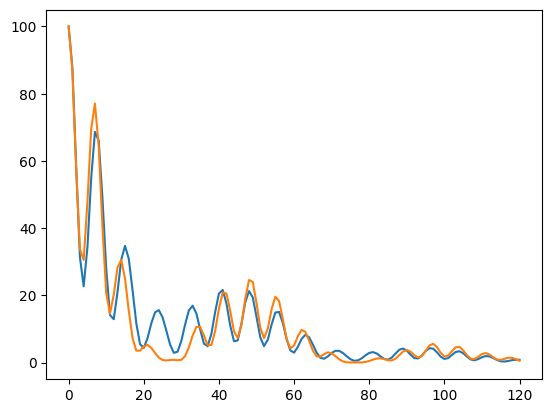

In [44]:
plt.plot(predicted[best_idx])
plt.plot(measurements_noisefree)

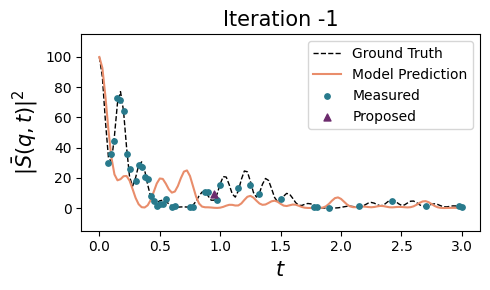

In [23]:
maxiter = len(param_mean)

colors = [palette_crest[0], palette_crest[-3], palette_flare[0]]

label_lst = ["$J$", "$D$", "$\gamma$"]
fig, ax = plt.subplots(1,1,figsize=(5,3))

ax.plot(times.squeeze(), measurements_noisefree, 'k--', label="Ground Truth", zorder=5, linewidth=1)
# # ax[1].plot(time_val, model_function((time_val,), obe_model.mean(), ()), 'r--', label="Ground Truth")
ax.plot(times.squeeze(), measurements_predicted, color=palette_flare[0], label="Model Prediction", zorder=5)
# ax.fill_between(times.squeeze(), measurements_predicted-utility_plot, measurements_predicted+utility_plot, color=palette_flare[0], zorder=1, alpha=0.25)
ax.scatter(measured_settings.squeeze()[:idx_plot], measured_observables.squeeze()[:idx_plot], label="Measured", s=15, color=palette_crest[-3], zorder=10)
ax.scatter(measured_settings.squeeze()[idx_plot], measured_observables.squeeze()[idx_plot], label="Proposed", s=25, color=palette_flare[-1], zorder=20, marker='^')
ax.legend(fontsize=10)
ax.set_xlabel('$t$', fontsize=15)
ax.set_ylim([-15, measurements_noisefree.max()+15])
ax.set_ylabel(r'$\left|\bar{S}(q,t)\right|^{2}$', fontsize=15)
ax.set_title(f"Iteration {idx_plot}", fontsize=15)

fig.tight_layout()
# fig.savefig(f'figs/paper/exp_steering_sqt_sample{idx}_iter{idx_plot}.pdf')

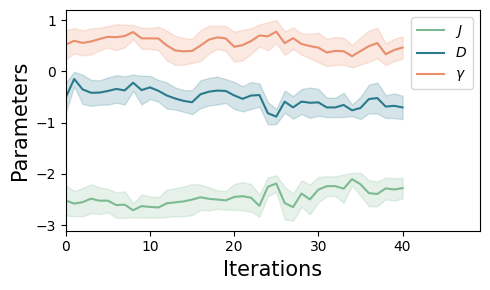

In [24]:
maxiter = len(param_mean)

colors = [palette_crest[0], palette_crest[-3], palette_flare[0], palette_flare[-3], palette_flare[-1]]

label_lst = ["$J$", "$D$", "$\gamma$", "$a$", "$\sigma$"]
fig, ax = plt.subplots(1,1,figsize=(5,3))
for i in range(5):
    
    if i <= 2:
        ax.fill_between(np.arange(maxiter), param_mean[:,i]-param_std[:,i], param_mean[:,i]+param_std[:,i], color=colors[i], alpha=0.2)
        # ax.hlines(param_true[i], -100, 100*maxiter, linestyles='--', color='gray')
        ax.plot(np.arange(maxiter), param_mean[:,i], color=colors[i], label=label_lst[i])
ax.set_xlim([-0.*maxiter, 1.2*maxiter])
ax.legend(loc='best', fontsize=10)
ax.set_xlabel("Iterations", fontsize=15)
ax.set_ylabel("Parameters", fontsize=15)

fig.tight_layout()
# fig.savefig(f'figs/paper/exp_steering_paramhist_sample{idx}.pdf')

In [25]:
pulse_width = 0.1
noise_level = 0.5
N_steps_bayes = 40
normalize_to_value = 100

times = np.linspace(0, 3, 121)
n_particles = 501
parameters = (
    np.random.uniform(-3.0, -2.0, n_particles),
    np.random.uniform(-1.0,-0.0, n_particles),
    np.random.uniform( 0.0, 1.0, n_particles),
    np.random.uniform( 0.0, 0.0, n_particles),
    np.random.uniform( 0.1, 2.0, n_particles)
    )

N_repeat = 10

mean gamma is:  tensor([[1.0218],
        [1.0218]])


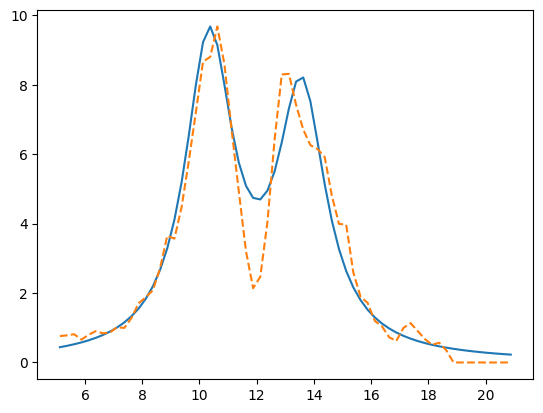

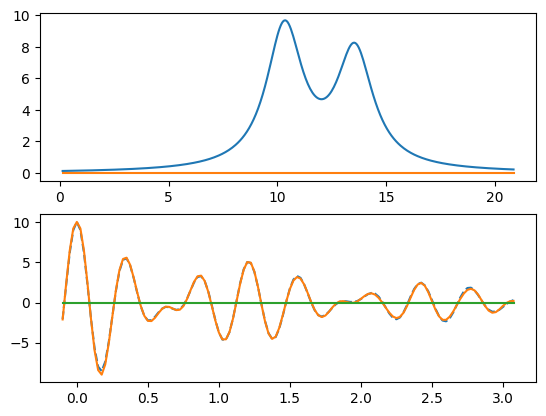

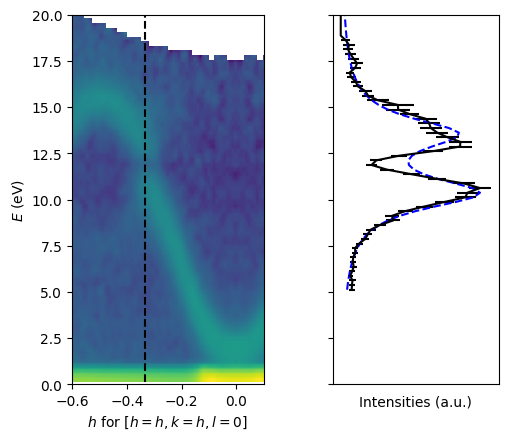

In [26]:
param_true, func_I_conv, func_I_noconv = prepare_CrI3_sample(
        times, pulse_width=0.1, mode='lorentzian', E_cutoff=5.0,
        amp_increase_factor=0.95, elas_bkg_amp_factor=0., elas_bkg_wid=0.5)
        
obe_sim = obe.MeasurementSimulator(
    lambda s, p, c: measure_function(s, p, c, func_I_conv), param_true, (), noise_level=noise_level, noise_mode='poisson')


In [27]:
results_dict = {}
for TASK_NAME in ['baseline', 'gd', 'random', 'sequential']:
    print(f"Benchmarking {TASK_NAME}")
    results_dict[TASK_NAME] = {_key: [] for _key in [
        'error', 'param_mean', 'param_std', 'measurement_errors', 'measurement_settings',
        'measurements', 'utility', 'particles', 'particle_weights', 'likyhd', 'times', 'signals'
    ]}
    results_dict[TASK_NAME]['param_true'] = jd_best
    if TASK_NAME in ['baseline', 'gd']:
        selection_method = 'unique_optimal'
        settings = (times, )
    elif TASK_NAME == 'random':
        selection_method = 'random'
        settings = (times, )
    elif TASK_NAME == 'sequential':
        selection_method = 'sequential'
        settings = (np.linspace(times.min(), times.max(), 40), )
    
    for i in tqdm(range(N_repeat)):
        bayes = BayesianInference(
            model_spec, settings, parameters, noise_level=noise_level,
            pulse_width=pulse_width, reference_setting_value=((0,), normalize_to_value),
            cost_repulse_height=10.0, cost_repulse_width=0.25,
            parameter_mins=(-3., -1., 0., 0., 0.1), parameter_maxs=(-2., 0., 1., 10., 2.), 
            selection_method=selection_method, utility_method='variance_full',
            model_uncertainty=False, device=device)
        bayes.obe_model.set_selection_method(selection_method)
        if TASK_NAME == 'gd':
            particles_hist, p_weights_hist, errors, likyhd_hist = bayes.run_N_steps_OptBayesExpt_w_GD(
                N_steps_bayes, obe_sim, N_GD=100, lr=0.1, ret_particles=True, verbose=False, init_bayes_guess=True,
                gd_seperation=14, error_criterion=25)
        else:
            particles_hist, p_weights_hist, errors, likyhd_hist = bayes.run_N_steps_OptBayesExpt_wo_GD(
                N_steps_bayes, obe_sim, ret_particles=True, verbose=False)
                
        param_mean = np.asarray(bayes.param_mean)
        param_std = np.asarray(bayes.param_std)

        results_dict[TASK_NAME]['error'].append(errors)
        results_dict[TASK_NAME]['param_mean'].append(param_mean.astype('float32'))
        results_dict[TASK_NAME]['param_std'].append(param_std.astype('float32'))
        results_dict[TASK_NAME]['measurement_errors'].append(np.asarray(errors).astype('float32'))
        _measurement_settings, _measurements = bayes.get_all_measurements()
        results_dict[TASK_NAME]['measurement_settings'].append(_measurement_settings.astype('float32'))
        results_dict[TASK_NAME]['measurements'].append(_measurements.astype('float32'))
        results_dict[TASK_NAME]['utility'].append(np.asarray(bayes.utility_list).astype('float32'))

        results_dict[TASK_NAME]['particles'].append(particles_hist.astype('float32'))
        results_dict[TASK_NAME]['particle_weights'].append(p_weights_hist.astype('float32'))
        results_dict[TASK_NAME]['likyhd'].append(likyhd_hist.astype('float32'))
        results_dict[TASK_NAME]['times'].append(times.astype('float32'))
        results_dict[TASK_NAME]['signals'].append(func_I_conv(times).astype('float32'))

Benchmarking baseline


100%|██████████| 10/10 [00:56<00:00,  5.61s/it]


Benchmarking gd


 70%|███████   | 7/10 [01:47<00:47, 15.71s/it]c:\Users\zhant\.conda\envs\sqt\lib\site-packages\optbayesexpt\particlepdf.py:199: RuntimeWarning: Degrees of freedom <= 0 for slice
  raw_covariance = np.cov(self.particles, aweights=self.particle_weights)
c:\Users\zhant\.conda\envs\sqt\lib\site-packages\numpy\lib\function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
100%|██████████| 10/10 [02:35<00:00, 15.60s/it]


Benchmarking random


100%|██████████| 10/10 [01:22<00:00,  8.21s/it]


Benchmarking sequential


100%|██████████| 10/10 [01:47<00:00, 10.71s/it]


In [28]:
torch.save(results_dict, 'figures/CrI3/CrI3_benchmark_results.pt')